## Initialization
N.B. [X-PSI](https://github.com/xpsi-group/xpsi) installation required to run this notebook. 

In [1]:
%matplotlib inline

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi
from xpsi.utilities.ProjectionTool import plot_projection_general

rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'legend.fontsize': 15})

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.2.2               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4.6
Imported nestcheck version: 0.2.1


In [2]:
import _auto_modules_ST.main as main

Parsing configuration file...
--main-import-statements
from xpsi.global_imports import gravradius
import math
import numpy as np
--XTI-exposure-time=1.0E+06
--XTI-count-matrix-path=/Users/dc1408/PhD_research/J0437/3c50/j0437_3c50_cl_evt_merged_phase_converted_to_counts.txt
--XTI-number-phase-bins=32
--XTI-arf-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-consim135p-teamonly-array50_arf.txt
--XTI-effective-area-scaling-factor=1.0
--XTI-arf-skiprows=3
--XTI-arf-low-column=0
--XTI-arf-high-column=1
--XTI-arf-area-column=2
--XTI-rmf-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-rmf6s-teamonly-array50_full_matrix.txt
--XTI-rmf-skiprows=3
--XTI-rmf-usecol=-1
--XTI-channels-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-rmf6s-teamonly-array50_full_energy_bounds.txt
--XTI-channel-energies-skiprows=3
--XTI-channel-energies-low-column=1
--XTI-input-bounds
0
1800
--XTI-channel-bounds
30
300
--XTI-energy-independent-effective-area-scaling-factor-value=1.0
--attenuation-path=/Users/dc1408/P

### Plotting tools

In [3]:
def veneer(x, y, axes, lw=1.0, length=8, ticksize=18):
    """
    Make the plots a little more aesthetically pleasing.

    Parameters:
        - x (tuple or None): Tuple specifying minor and major tick locations for the x-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - y (tuple or None): Tuple specifying minor and major tick locations for the y-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - axes (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes to customize.
        - lw (float, optional): Line width for tick marks and spines in points. Std is 1.0.
        - length (float, optional): Length of tick marks in points. Std is 8.
        - ticksize (float, optional): Font size for tick labels. Std is 18.
    
    Returns:
        None. This function customizes the appearance of tick marks, tick labels, and spines on a matplotlib axes..
    """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    
    plt.setp(list(axes.spines.values()), linewidth=lw, color='black')

In [4]:
def plot_flux():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')

    temp = np.sum(main.photosphere.signal[0][0], axis=0)
    ax.plot(main.hot.phases_in_cycles, temp/np.max(temp), 'o-', color='k', lw=0.25, markersize=1)
    ax.grid(linestyle="-.", color='grey',linewidth=0.7)

    veneer((0.05,0.2), None, ax)

In [5]:
def plot_counts(spot_plt):
    """ Plot hot region signals after telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Counts')
    ax.set_xlabel('Phase [cycles]')

    ax.plot(np.linspace(0.0, 1.0, 32), spot_plt, 'o-', color='r', lw=0.5, markersize=2)
    ax.grid(linestyle="-.", color='grey',linewidth=0.7)
    
    veneer((0.05,0.2), None, ax)

In [6]:
def plot_cell_mesh():
    """ Plot the surface cell mesh grid of a hotspot """
    with plt.rc_context({'font.size': 50, 'legend.fontsize': 34}):

        fig = plt.figure(figsize = (22,20))

        gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.2)
        ax = plt.subplot(gs[0])

        h = main.hot.objects[0]
        z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
        patches = plt.pcolormesh(z,
                                vmin = np.min(z),
                                vmax = np.max(z),
                                cmap = cm.magma,
                                linewidth = 1.0,
                                rasterized = True,
                                edgecolor='black')

        ax_cb = plt.subplot(gs[1])
        cb = plt.colorbar(patches,
                        cax = ax_cb,
                        ticks = MultipleLocator(0.2))

        cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
        cb.solids.set_edgecolor('face')

        cb.outline.set_linewidth(1.0)

### Synthesis setup

In [7]:
class SynthesiseData(main.xpsi.Data):
    """ Custom data container to enable synthesis. """

    def __init__(self, channels, phases, first, last):

        self.channels = channels
        self._phases = phases

        try:
            self._first = int(first)
            self._last = int(last)
        except TypeError:
            raise TypeError('The first and last channels must be integers.')
        if self._first >= self._last:
            raise ValueError('The first channel number must be lower than the '
                             'the last channel number.')

In [8]:
_data = SynthesiseData(main.XTI.instrument.channels, np.linspace(0.0, 1.0, 33), 0, len(main.XTI.instrument.channels) - 1) 

Setting channels for event data...
Channels set.


In [9]:
from xpsi.tools.synthesise import synthesise_exposure as _synthesise

In [10]:
bkg = np.zeros((270, 33))

def synthesise(self,
               exposure_time,
               require_background_counts=np.sum(bkg),
               name='synthetic',
               directory='./',
               **kwargs):
    
    self._expected_counts, synthetic, _= _synthesise(exposure_time,
                                                     self._data.phases,
                                                     self._signals,
                                                     self._phases,
                                                     self._shifts,
                                                     require_background_counts,
                                                     bkg)
    try:
        if not os.path.isdir(directory):
            os.mkdir(directory)
    except OSError:
        print('Cannot create write directory.')
        raise

    self._write(self.expected_counts,
                filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                fmt = '%.8e')
    
def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= len(self._data.channels)

    phases = np.arange(0, 32)
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = self._data.channels[i], phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%-3u', '%-3u', "%-3.3f"])# + [fmt])

In [11]:
main.CustomSignal.synthesise = synthesise
main.CustomSignal._write = _write

In [12]:
signal = main.CustomSignal(data = _data,
                           instrument = main.XTI.instrument,
                           background = None,
                           interstellar = main.interstellar,
                           prefix='NICER',
                           cache=True)

likelihood = main.xpsi.Likelihood(star = main.star, signals = signal, num_energies = main.args.number_energies, threads=1)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.


In [13]:
# Printing free parameters that need to be fixed to certain values for data generation
likelihood

Free parameters
---------------
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
p__omit_colatitude: The colatitude of the centre of the omission region [radians].
p__omit_radius: The angular radius of the (circular) omission region [radians].
p__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].
neutral_hydrogen_column_density: Neutral hydrogen column density in units of the fiducial column density.

## Resolution settings to consider

N.B. The following sections of the notebook have to be re-run for different X-PSI resolution settings. These settings need to be adjusted in the `./_auto_modules_ST/config.ini` file in the same directory as the notebook. Following are the different resolution settings that have been used in this work (shown as commented code blocks below). You can copy-paste the releavant code-blocks into `./_auto_modules_ST/config.ini`. The high resolution settings are present in the config file by default.

### Ultra resolution settings

In [14]:
# ##---------------------------------##
# ## "p" hot region resolution flags ##
# ##---------------------------------##
# --p-sqrt-num-cells=256
# --p-min-sqrt-num-cells=256
# --p-max-sqrt-num-cells=256
# --p-num-leaves=512
# --p-num-rays=1024 

# ##-------------------------##
# ## global resolution flags ##
# ##-------------------------##
# --image-order-limit=3
# --number-energies=512
# #--maximum-energy-ray-tracing=

### High resolution settings
(present by default in `config.ini`)

In [15]:
# ##---------------------------------##
# ## "p" hot region resolution flags ##
# ##---------------------------------##
# --p-sqrt-num-cells=64
# --p-min-sqrt-num-cells=64
# --p-max-sqrt-num-cells=64
# --p-num-leaves=128
# --p-num-rays=640

# ##-------------------------##
# ## global resolution flags ##
# ##-------------------------##
# --image-order-limit=3
# --number-energies=256
# #--maximum-energy-ray-tracing=

### Standard resolution settings

In [16]:
# ##---------------------------------##
# ## "p" hot region resolution flags ##
# ##---------------------------------##
# --p-sqrt-num-cells=32
# --p-min-sqrt-num-cells=32
# --p-max-sqrt-num-cells=32
# --p-num-leaves=64
# --p-num-rays=512 

# ##-------------------------##
# ## global resolution flags ##
# ##-------------------------##
# --image-order-limit=3
# --number-energies=128
# #--maximum-energy-ray-tracing=

### Low resolution settings

In [17]:
# ##---------------------------------##
# ## "p" hot region resolution flags ##
# ##---------------------------------##
# --p-sqrt-num-cells=16
# --p-min-sqrt-num-cells=16
# --p-max-sqrt-num-cells=16
# --p-num-leaves=32
# --p-num-rays=100 

# ##-------------------------##
# ## global resolution flags ##
# ##-------------------------##
# --image-order-limit=3
# --number-energies=64
# #--maximum-energy-ray-tracing=

## Ring-Eq

### Synthetic data generation

In [18]:
p = [math.cos(np.radians(137.0)),    #cos_i
     0.0,    # phase
     math.pi/2.0,    # super colatitude
     0.5,    # super radius
     6.0,    # temperature
     math.pi/2.0,    # omit colatitude
     0.25,    # omit radius
     0.2,    # omit azimuth
     5.0]    # N_H

NICER_kwargs = dict(exposure_time = 1.0E+06,
                    require_background_counts = 0.0,
                    name = 'Ring_Eq',
                    directory = '../Pulse_profiles_by_diff_codes/XPSI/Hi_res')
                              # If changing the resolution settings in config.ini directory,
                              # Make sure to change the output directory

likelihood.synthesise(p, force=True, NICER=NICER_kwargs)

In [19]:
LowXPSI_Ring_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Low_res/Ring_Eq_expected_hreadable.dat')
StdXPSI_Ring_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Std_res/Ring_Eq_expected_hreadable.dat')
HiXPSI_Ring_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Hi_res/Ring_Eq_expected_hreadable.dat')
UltraXPSI_Ring_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Ring_Eq_expected_hreadable.dat')

### Diagnostic plots

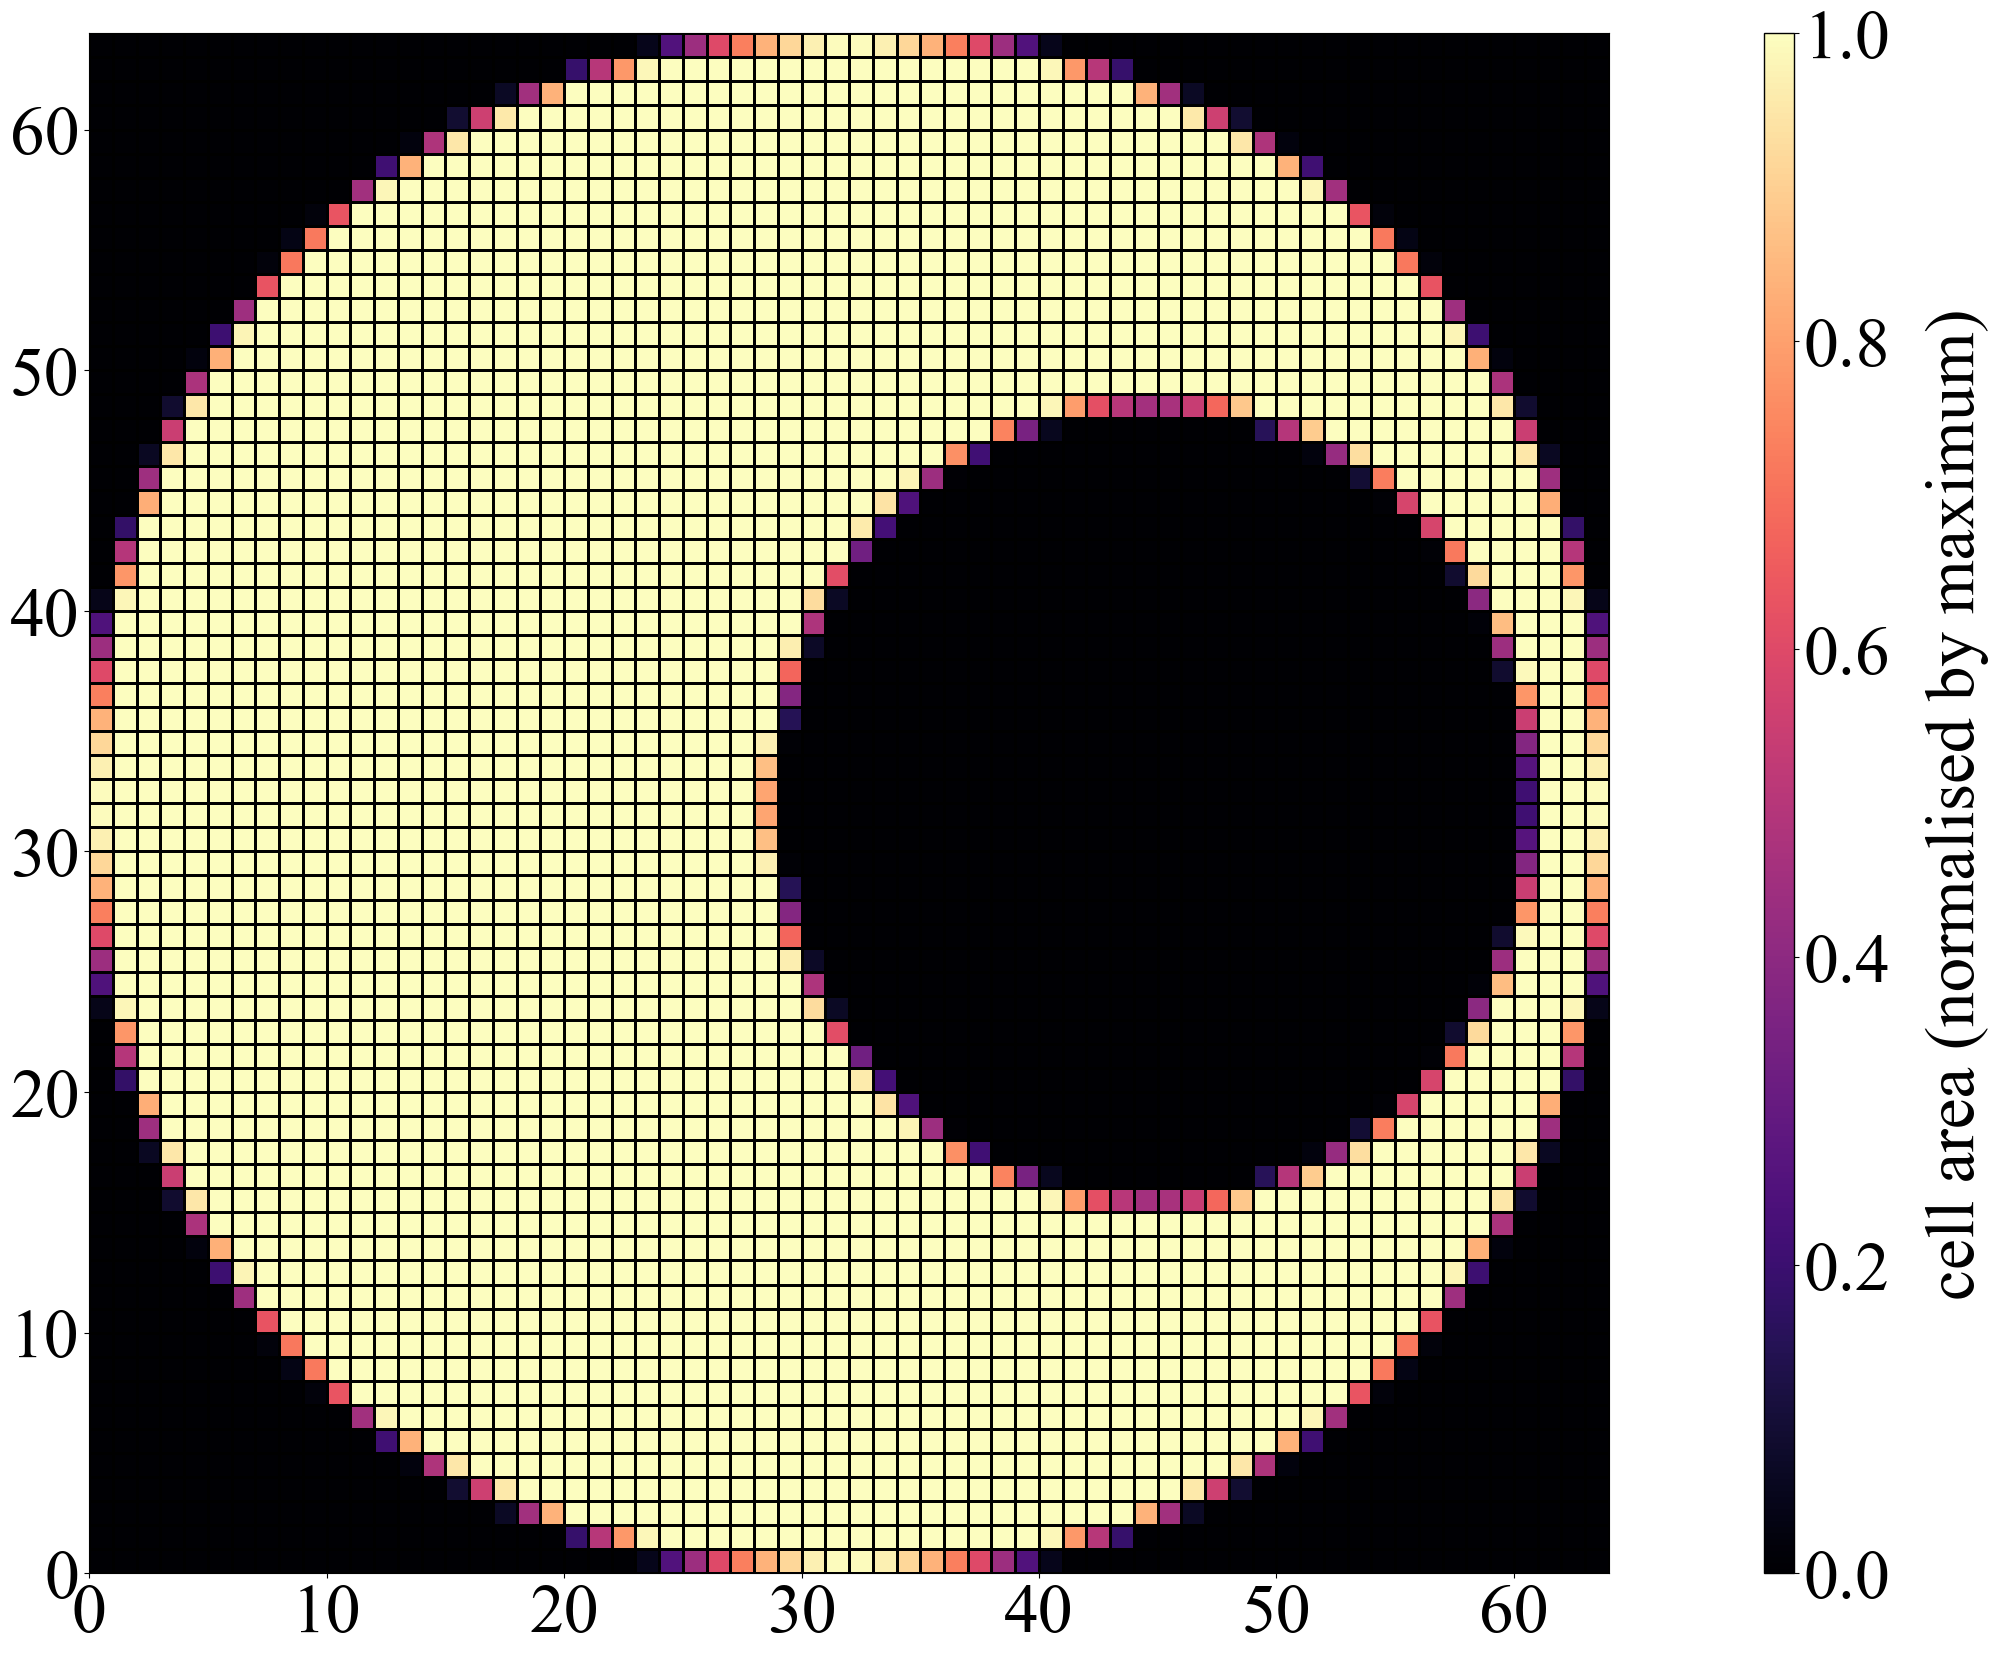

In [20]:
# Plot generated using High-res. For plotting the cell meshes corresponding to 
# other resolution settings, adjust the config.ini file and restart and rerun the notebook.
_ = plot_cell_mesh()

In [21]:
HiXPSI_Ring_Eq_plt = np.zeros(32)
for i in range(0,32):
    HiXPSI_Ring_Eq_plt[i] = np.sum(HiXPSI_Ring_Eq[:,2][i:33*270:32])

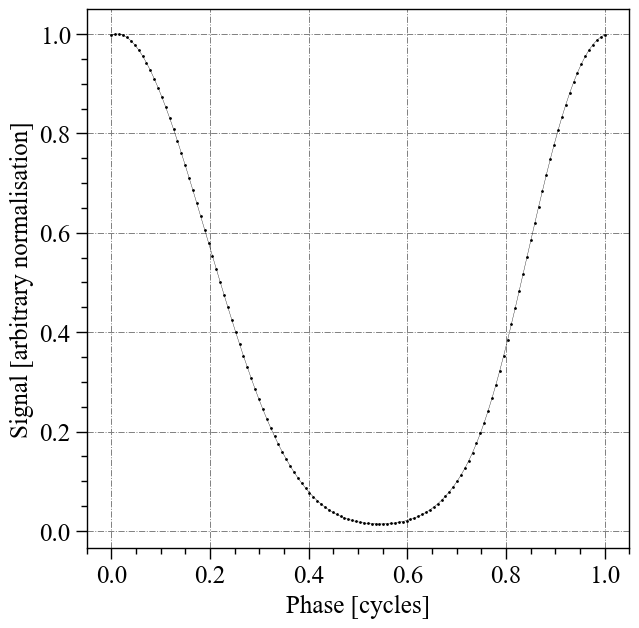

In [22]:
_ = plot_flux() #photosphere signal

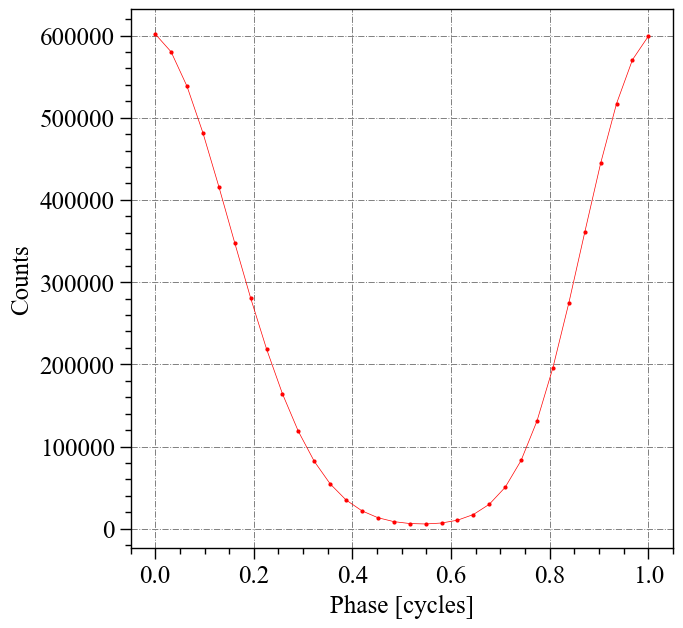

In [23]:
_ = plot_counts(HiXPSI_Ring_Eq_plt) #registered counts

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

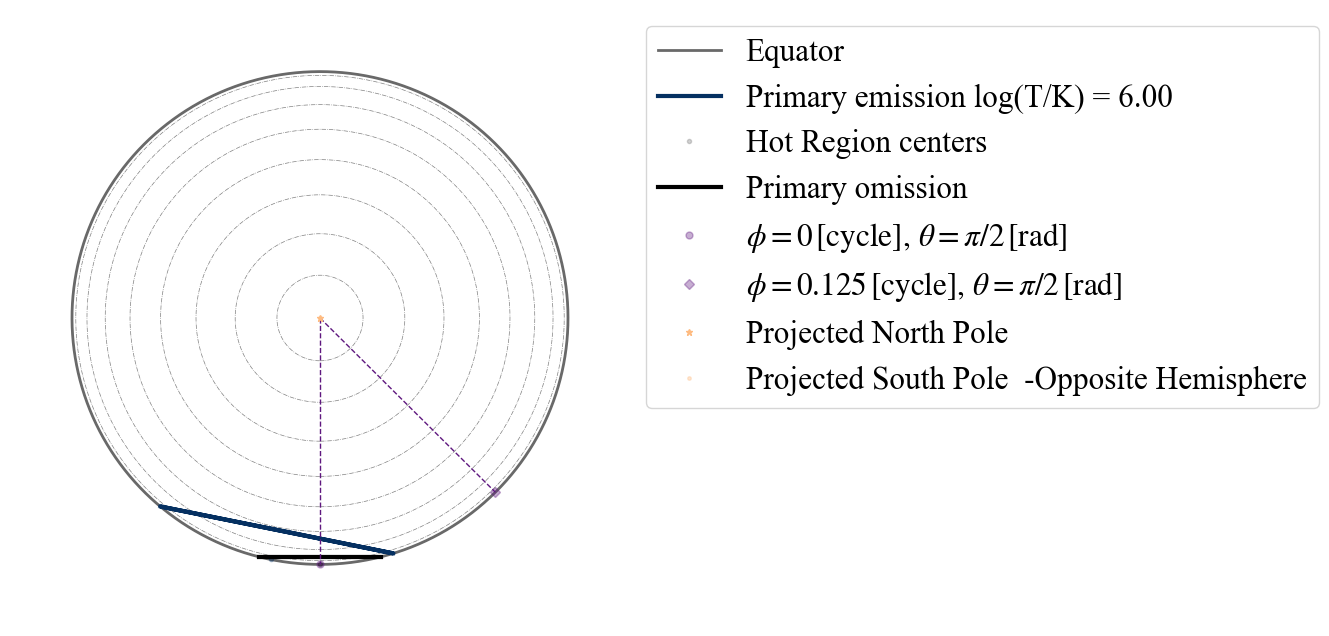

In [24]:
plot_projection_general(likelihood,"EST",[0,0,1],"NP",
                        SaveFlag = False, dir = "./", 
                        Name = "Ring_Eq", POVname='NorthPole', extension = ".png")

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

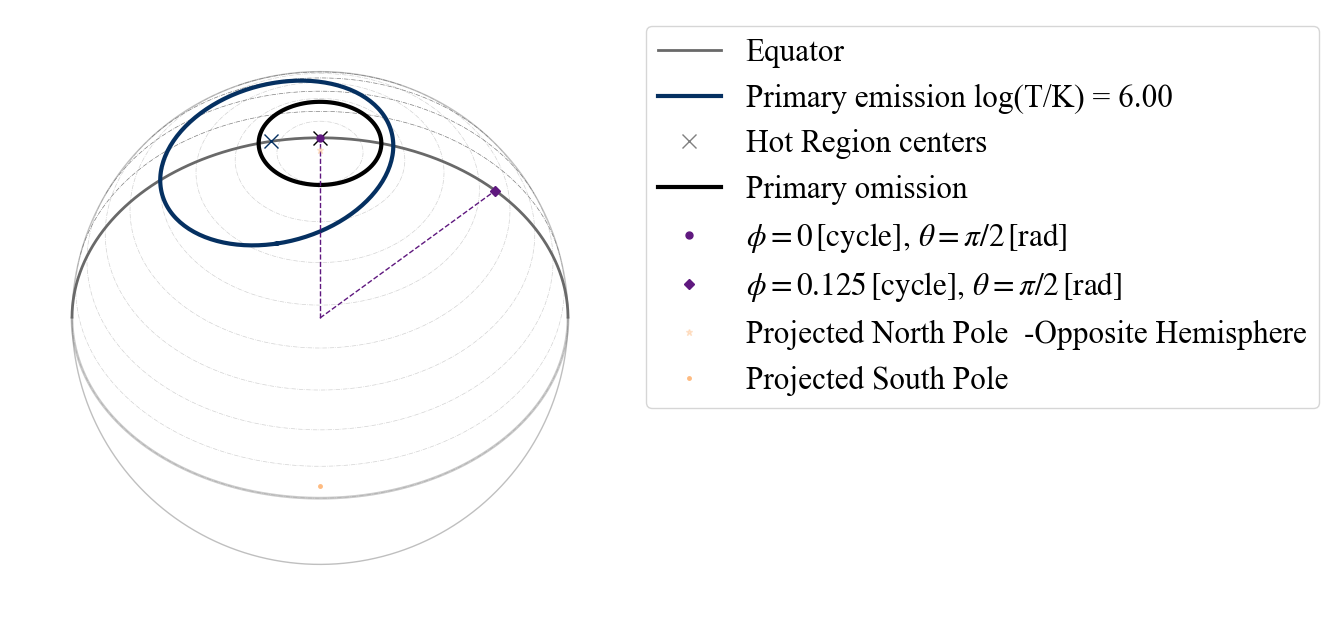

In [25]:
plot_projection_general(likelihood,"EST","I","NP",
                        SaveFlag = False, dir = "./", 
                        Name = "Ring_Eq", POVname='NorthPole', extension = ".png")

## Ring-Polar

### Synthetic data generation

In [26]:
p = [math.cos(np.radians(137.0)),    #cos_i
     0.0,    # phase
     math.pi - 0.001,    # super colatitude
     0.05,    # super radius
     6.0,    # temperature
     math.pi - 0.001,    # omit colatitude
     0.025,    # omit radius
     0.02,    # omit azimuth
     5.0]    # N_H

NICER_kwargs = dict(exposure_time = 1.0E+06,
                    require_background_counts = 0.0,
                    name = 'Ring_Polar',
                    directory = '../Pulse_profiles_by_diff_codes/XPSI/Hi_res')

likelihood.synthesise(p, force=True, NICER=NICER_kwargs)

In [27]:
LowXPSI_Ring_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Low_res/Ring_Polar_expected_hreadable.dat')
StdXPSI_Ring_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Std_res/Ring_Polar_expected_hreadable.dat')
HiXPSI_Ring_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Hi_res/Ring_Polar_expected_hreadable.dat')
UltraXPSI_Ring_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Ring_Polar_expected_hreadable.dat')

### Diagnostic Plots

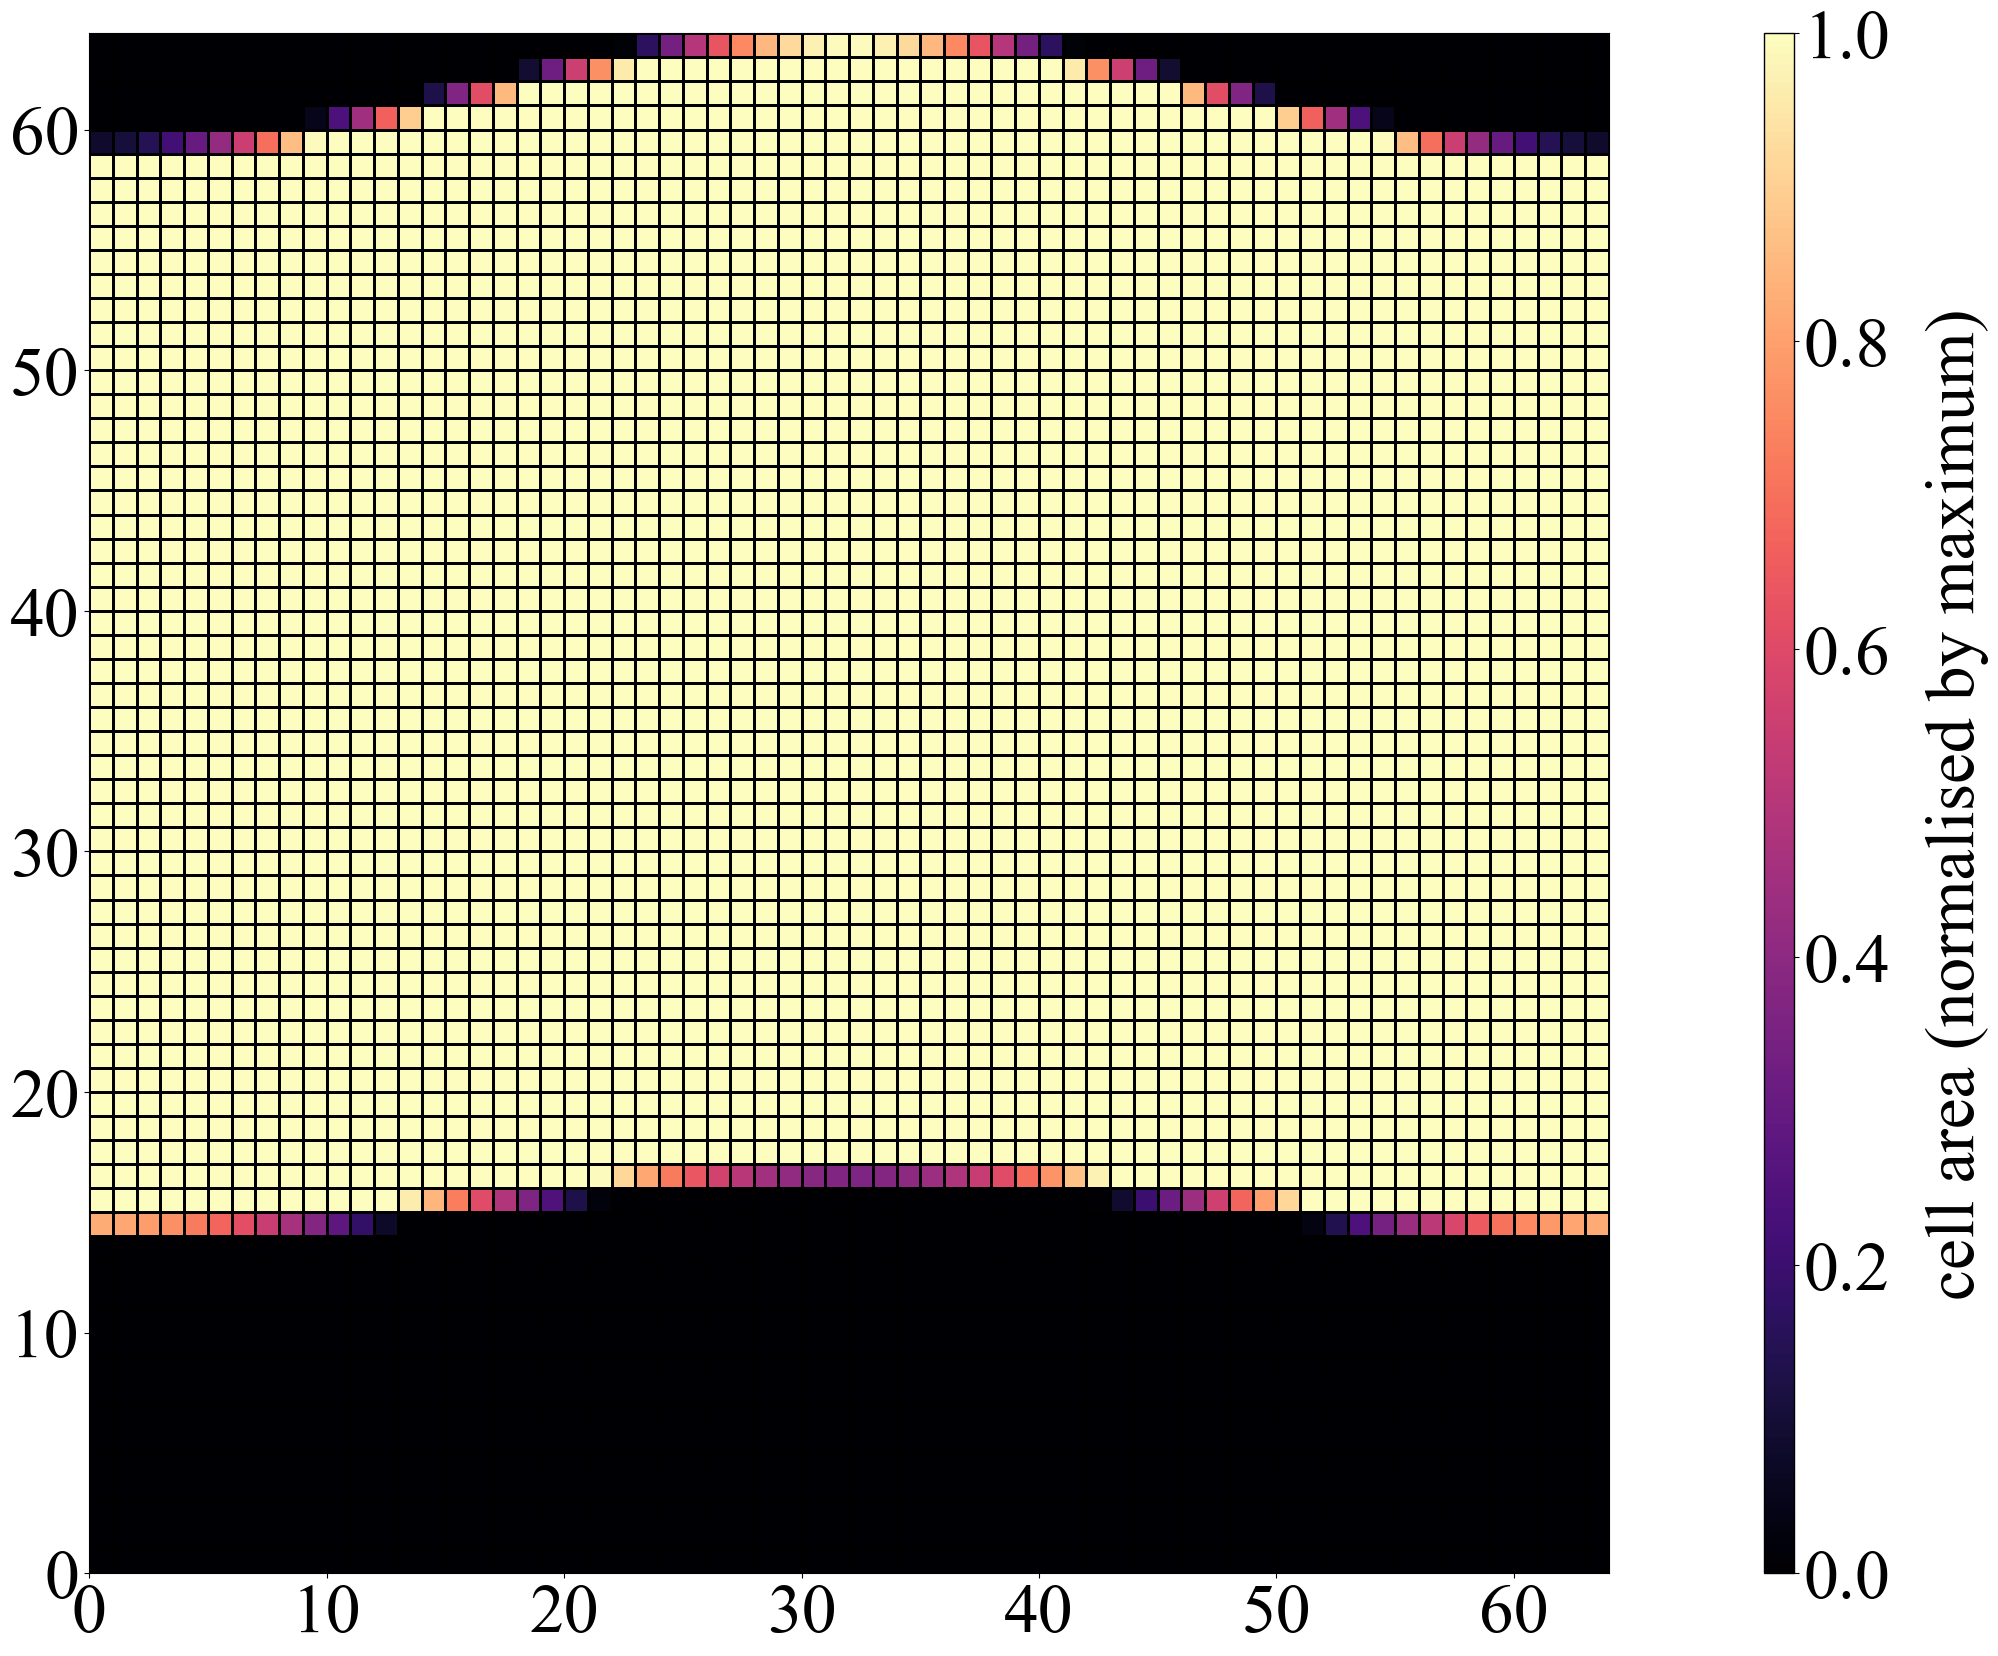

In [28]:
# Plot generated using High-res. For plotting the cell meshes corresponding to 
# other resolution settings, adjust the config.ini file and restart and rerun the notebook.
_ = plot_cell_mesh()

Note that the cell mesh representation here doesn't look like a distinct hole like in the previous case due to projection of 3D oblate spheroidal mesh distribution on a 2D Cartesian plane.

In [29]:
HiXPSI_Ring_Polar_plt = np.zeros(32)
for i in range(0,32):
    HiXPSI_Ring_Polar_plt[i] = np.sum(HiXPSI_Ring_Polar[:,2][i:33*270:32])

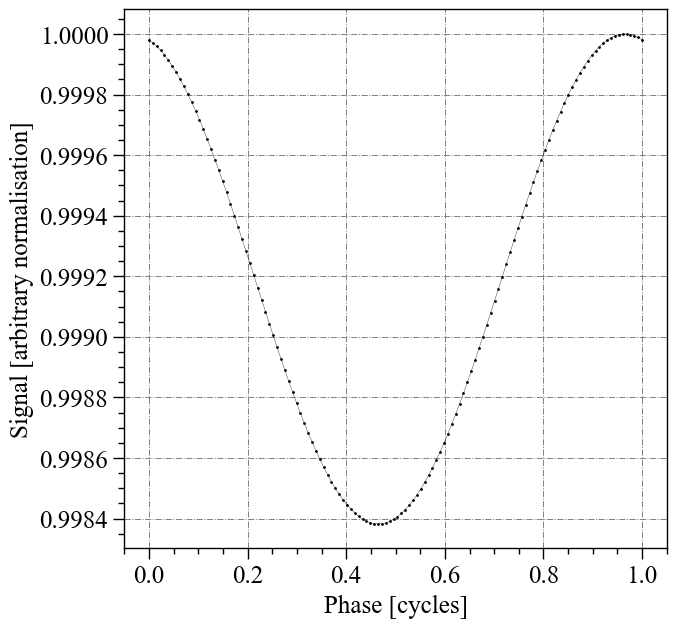

In [30]:
_ = plot_flux() #photosphere signal

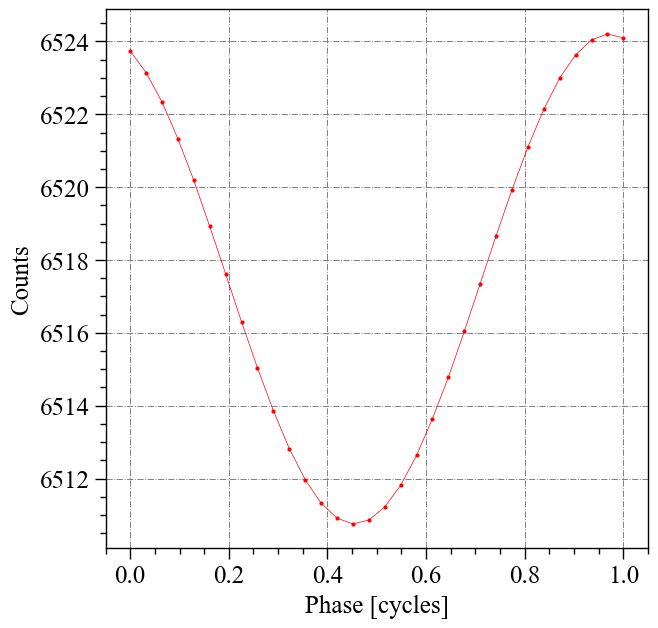

In [31]:
_ = plot_counts(HiXPSI_Ring_Polar_plt) #registered counts

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

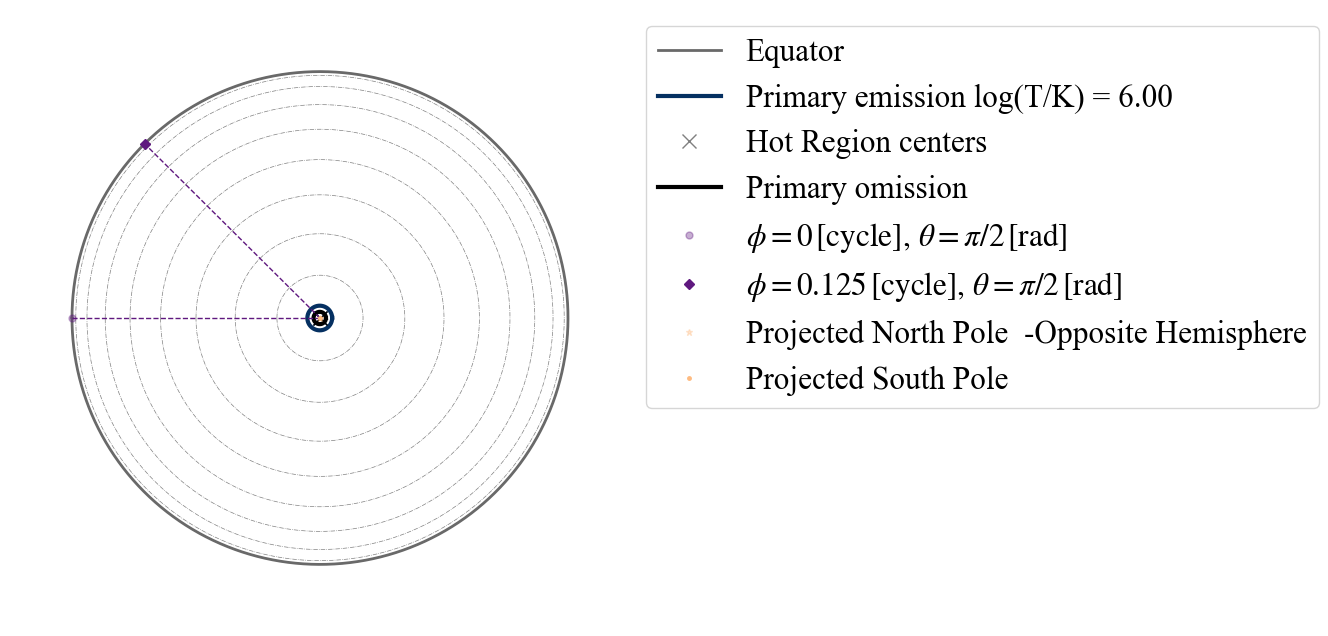

In [32]:
plot_projection_general(likelihood,"EST",[0,0,-1],"SP",
                        SaveFlag = False, dir = "./", 
                        Name = "Ring_Polar", POVname='SouthPole', extension = ".png")

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

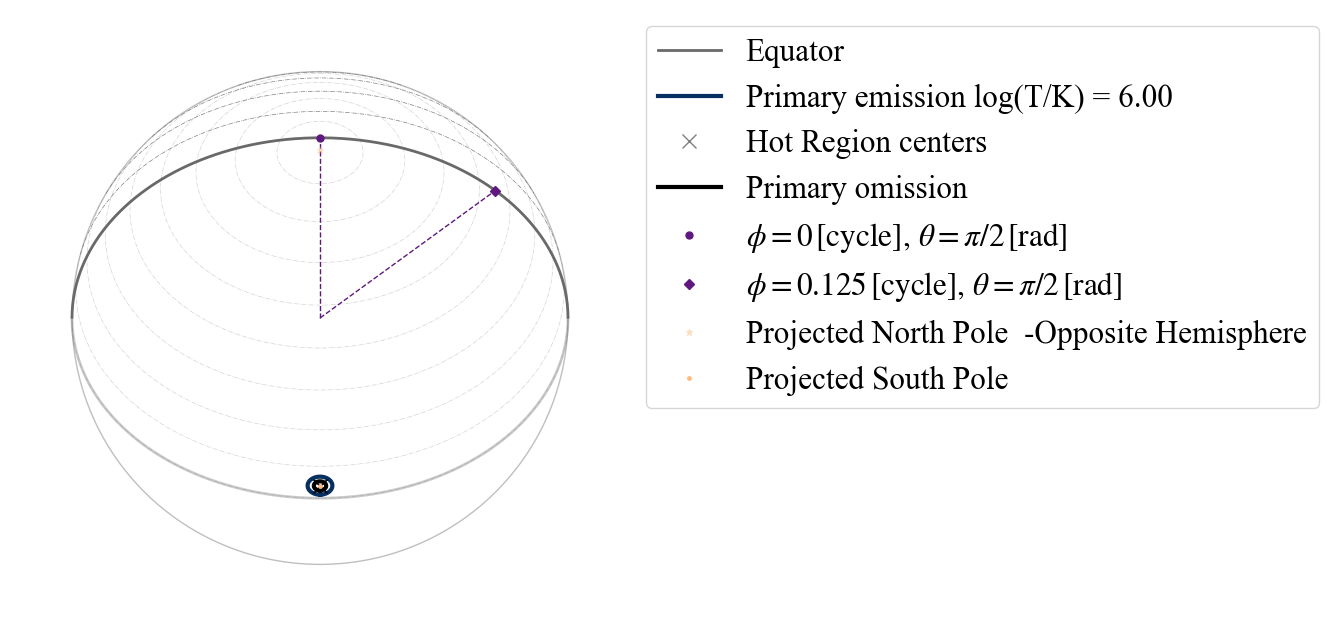

In [33]:
plot_projection_general(likelihood,"EST","I","NP",
                        SaveFlag = False, dir = "./", 
                        Name = "Ring_Polar", POVname='NorthPole', extension = ".png")

## Crescent-Eq

### Synthetic data generation

In [34]:
p = [math.cos(np.radians(137.0)),    #cos_i
     0.25,    # phase (Set to 0.25 for clearer view in the projection plot)
     1.0,    # super colatitude
     1.4,    # super radius
     6.0,    # temperature
     0.5,    # omit colatitude
     math.pi/2 - 0.001,    # omit radius
     1.0,    # omit azimuth
     5.0]    # N_H

NICER_kwargs = dict(exposure_time = 1.0E+06,
                    require_background_counts = 0.0,
                    name = 'Crescent_Eq',
                    directory = '../Pulse_profiles_by_diff_codes/XPSI/Hi_res')

likelihood.synthesise(p, force=True, NICER=NICER_kwargs) #SEED=0

In [35]:
LowXPSI_Crescent_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Low_res/Crescent_Eq_expected_hreadable.dat')
StdXPSI_Crescent_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Std_res/Crescent_Eq_expected_hreadable.dat')
HiXPSI_Crescent_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Hi_res/Crescent_Eq_expected_hreadable.dat')
UltraXPSI_Crescent_Eq = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Crescent_Eq_expected_hreadable.dat')

### Diagnostic Plots

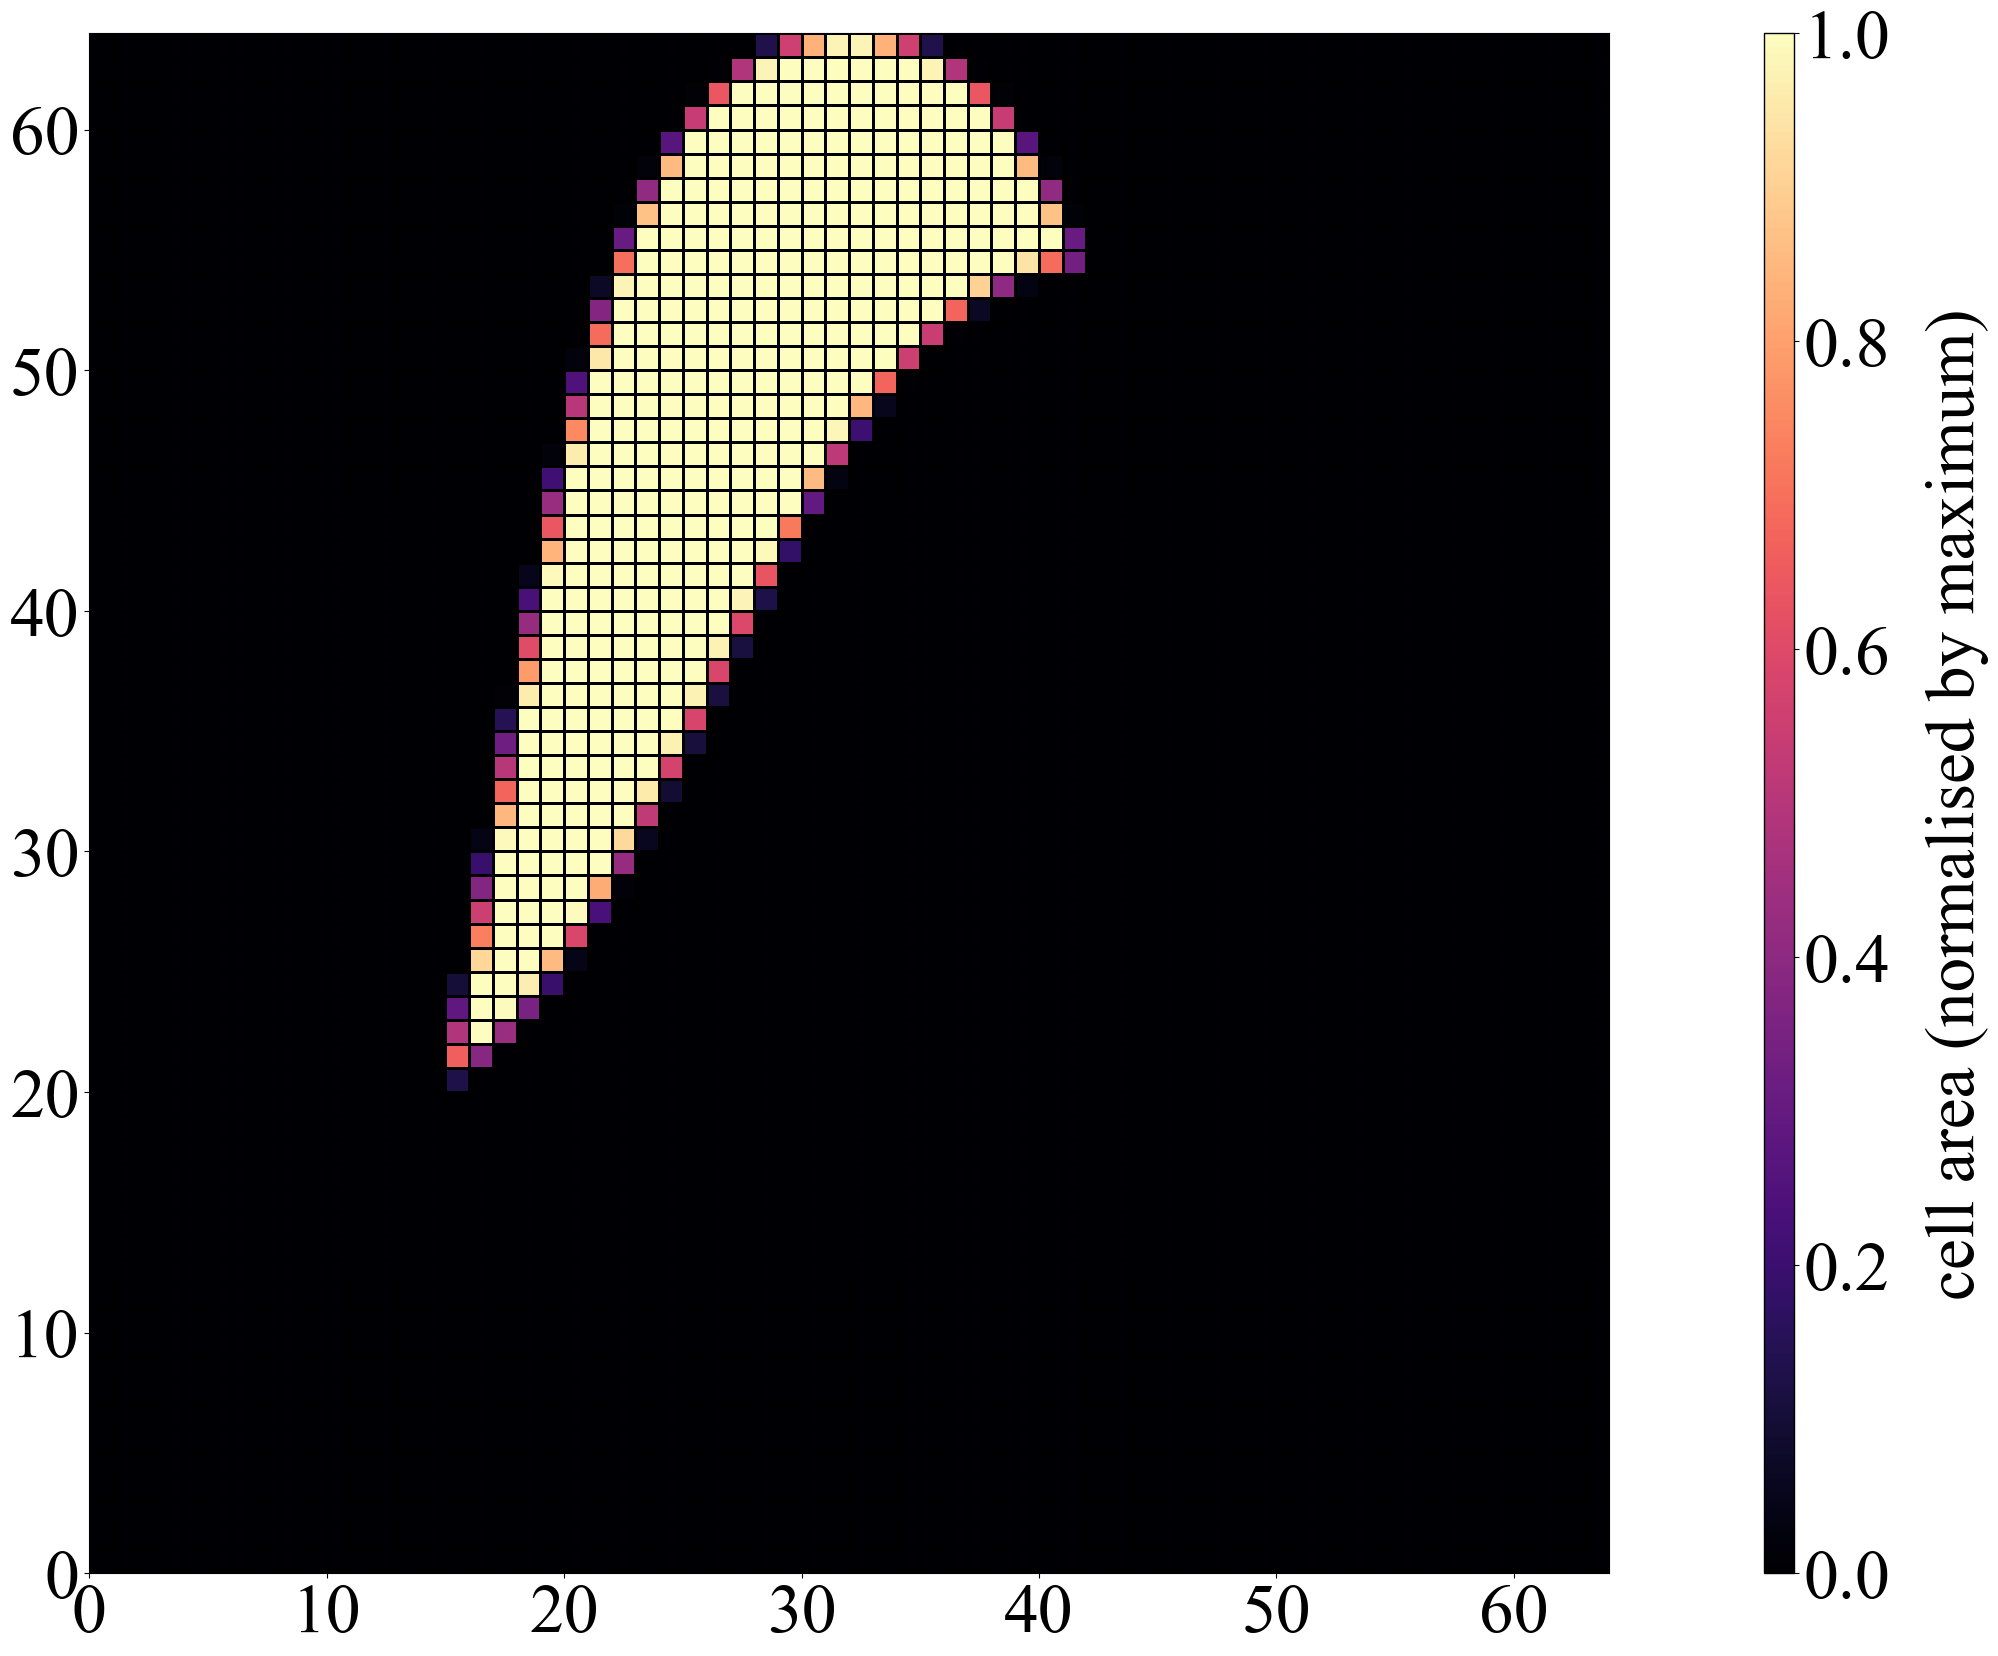

In [36]:
# Plot generated using High-res. For plotting the cell meshes corresponding to 
# other resolution settings, adjust the config.ini file and restart and rerun the notebook.
_ = plot_cell_mesh()

In [37]:
HiXPSI_Crescent_Eq_plt = np.zeros(32)
for i in range(0,32):
    HiXPSI_Crescent_Eq_plt[i] = np.sum(HiXPSI_Crescent_Eq[:,2][i:33*270:32])

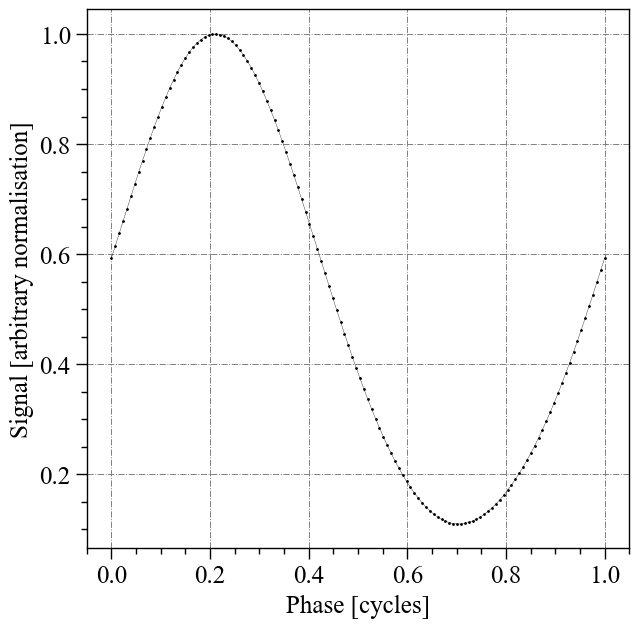

In [38]:
_ = plot_flux() #photosphere signal

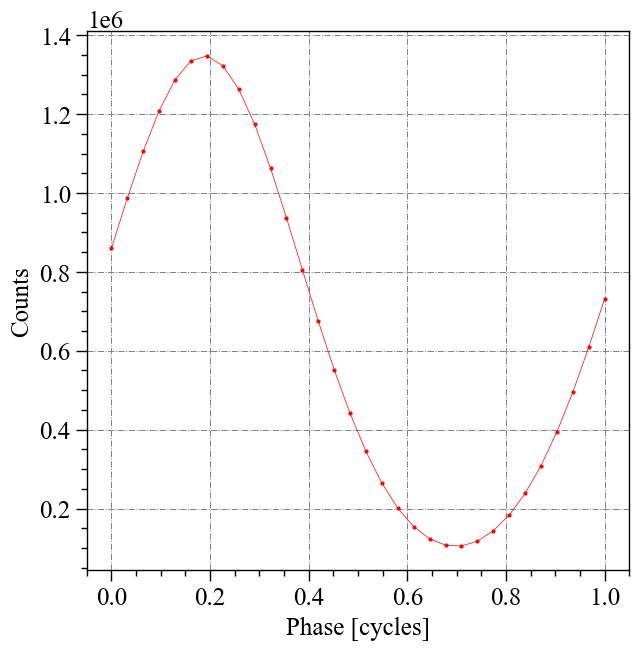

In [39]:
_ = plot_counts(HiXPSI_Crescent_Eq_plt) #registered counts

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

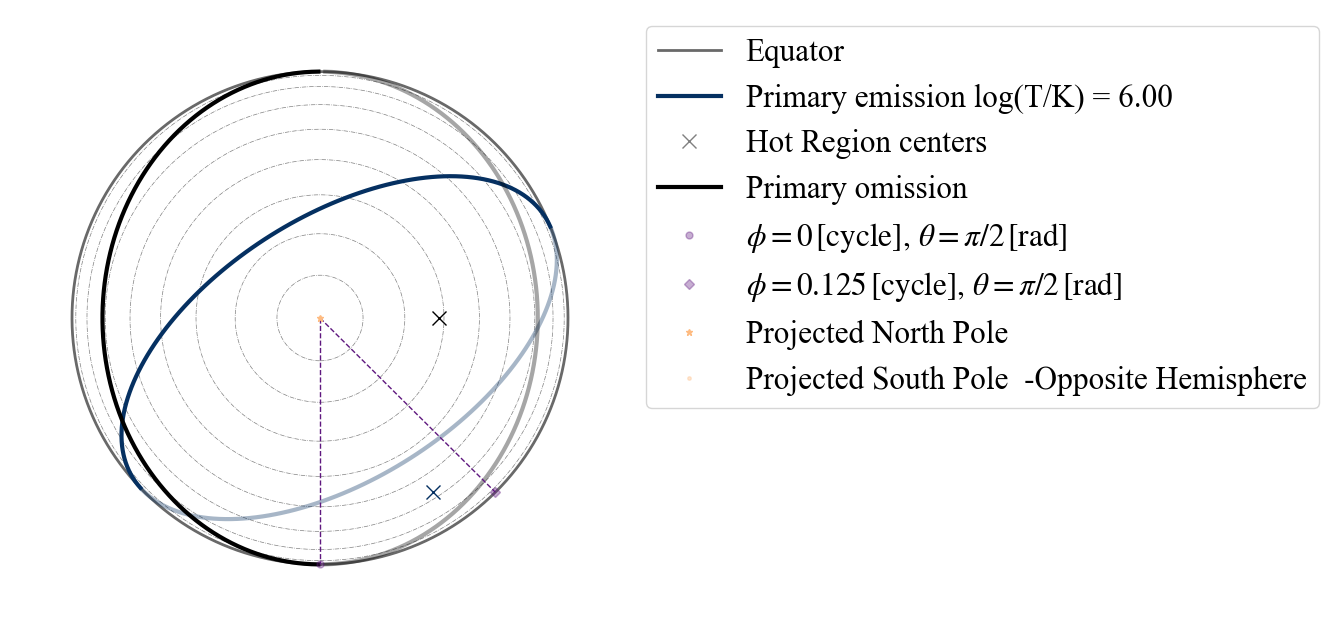

In [40]:
# N.B. This plot was generateed having set phase = 0.25 instead of 
# phase = 0.0 (which is used to generate the synthetic data) just for better visualization

plot_projection_general(likelihood,"PST",[0,0,1],"NP",
                        SaveFlag = False)

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

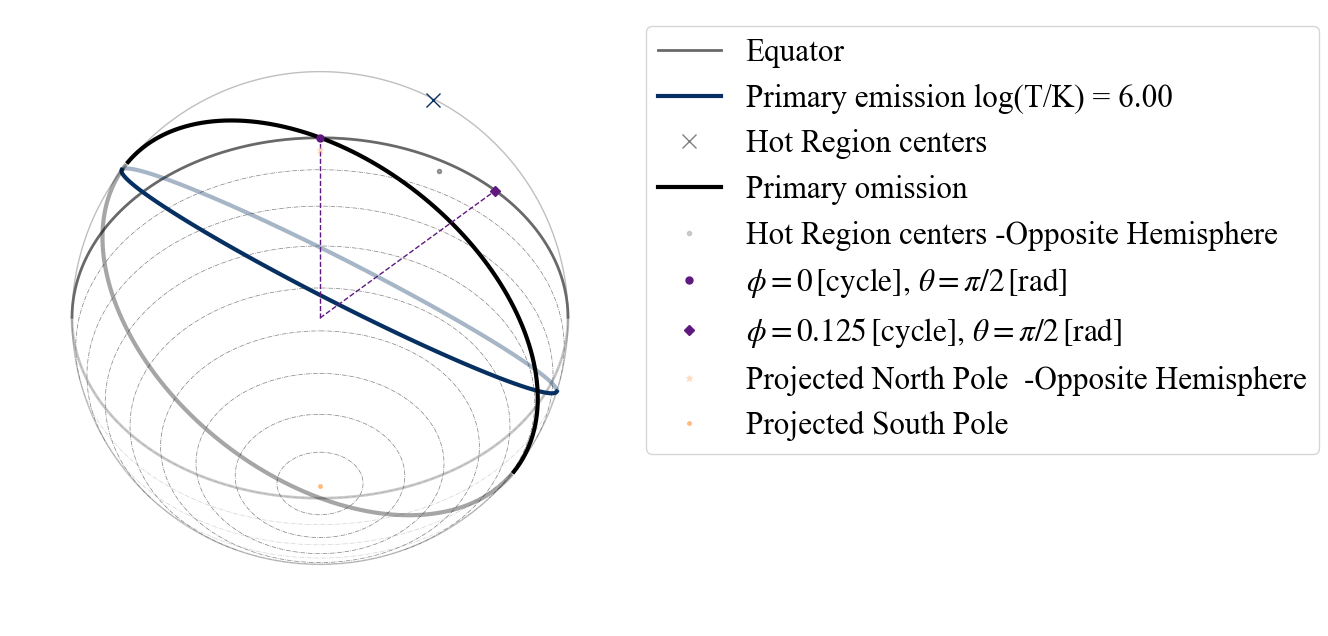

In [41]:
# N.B. This plot was generateed having set phase = 0.25 instead of 
# phase = 0.0 (which is used to generate the synthetic data) just for better visualization

plot_projection_general(likelihood,"PST","I","SP",
                        SaveFlag = False)

## Crescent-Polar

### Synthetic data generation

In [42]:
p = [math.cos(np.radians(137.0)),    #cos_i
     0.0,    # phase
     1.15,    # super colatitude
     1.3,    # super radius
     6.0,    # temperature
     1.75,    # omit colatitude
     math.pi/2 - 0.001,    # omit radius
     0.1,    # omit azimuth
     5.0]    # N_H

NICER_kwargs = dict(exposure_time = 1.0E+06,
                    require_background_counts = 0.0,
                    name = 'Crescent_Polar',
                    directory = '../Pulse_profiles_by_diff_codes/XPSI/Hi_res')

likelihood.synthesise(p, force=True, NICER=NICER_kwargs) #SEED=0

In [43]:
LowXPSI_Crescent_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Low_res/Crescent_Polar_expected_hreadable.dat')
StdXPSI_Crescent_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Std_res/Crescent_Polar_expected_hreadable.dat')
HiXPSI_Crescent_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Hi_res/Crescent_Polar_expected_hreadable.dat')
UltraXPSI_Crescent_Polar = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Crescent_Polar_expected_hreadable.dat')

### Appendix figure
The 4 panels shown in the appnedix figure have been generated by re-running the notebook for the different resolution settings

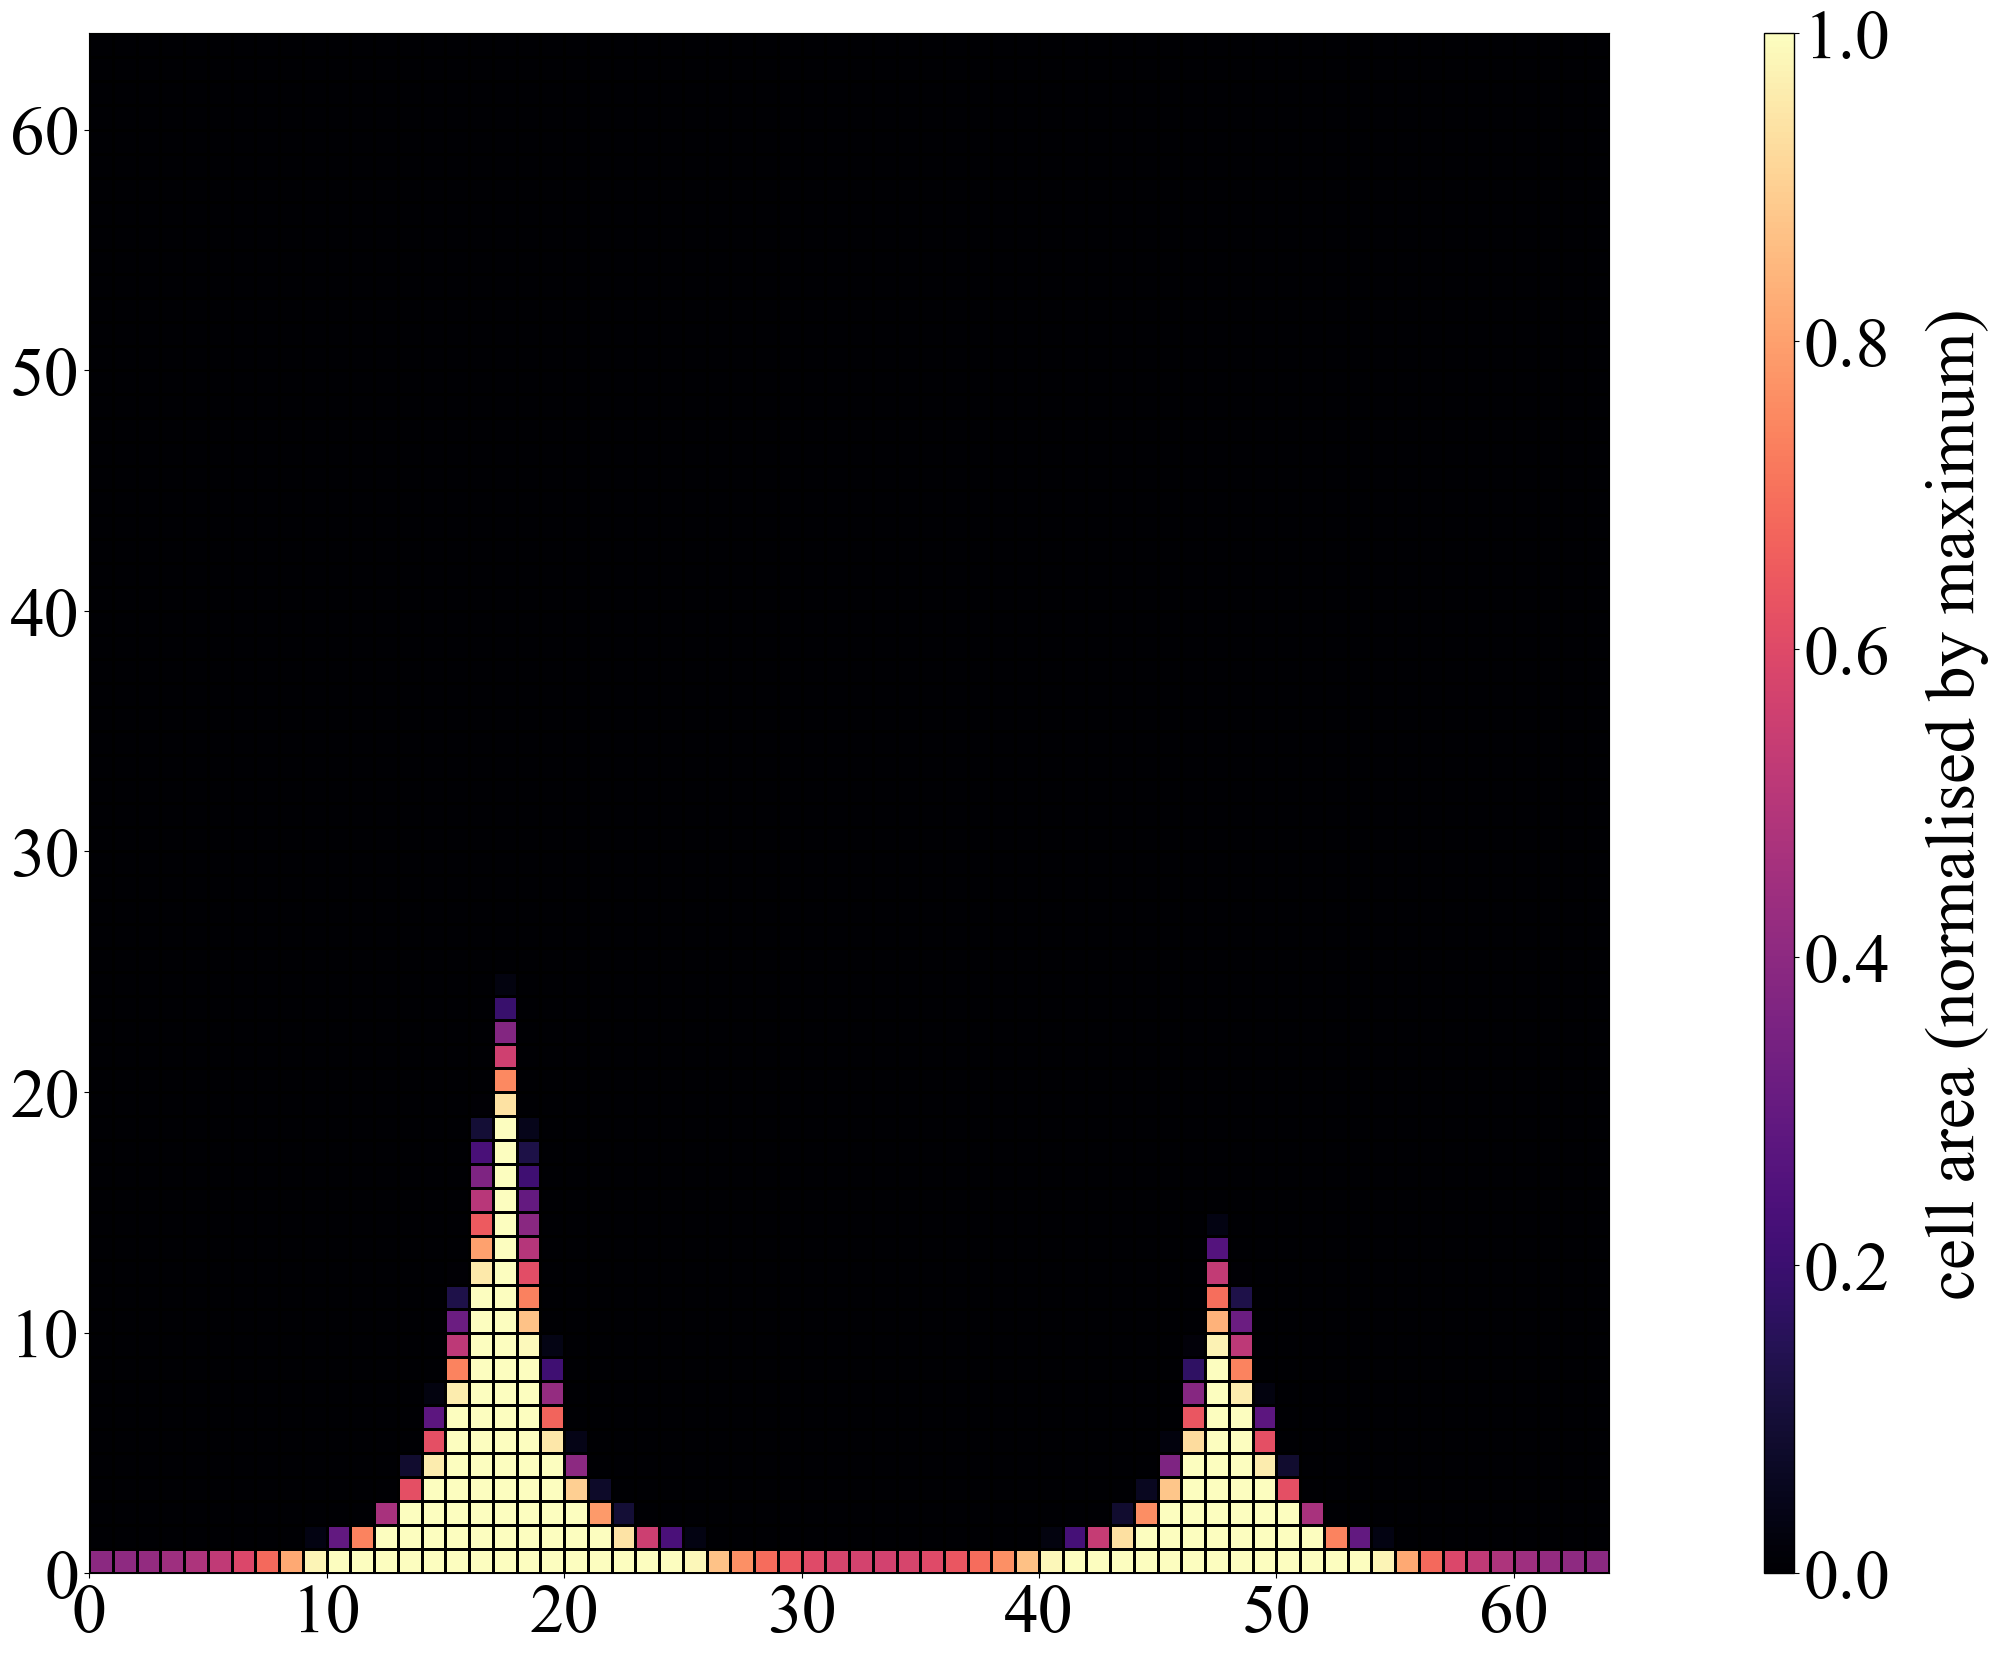

In [44]:
# Plot generated using High-res settings. For plotting the cell meshes corresponding to 
# other resolution settings, adjust the config.ini file and restart and rerun the notebook.
_ = plot_cell_mesh()

### Diagnostic plots

In [45]:
HiXPSI_Crescent_Polar_plt = np.zeros(32)
for i in range(0,32):
    HiXPSI_Crescent_Polar_plt[i] = np.sum(HiXPSI_Crescent_Polar[:,2][i:33*270:32])

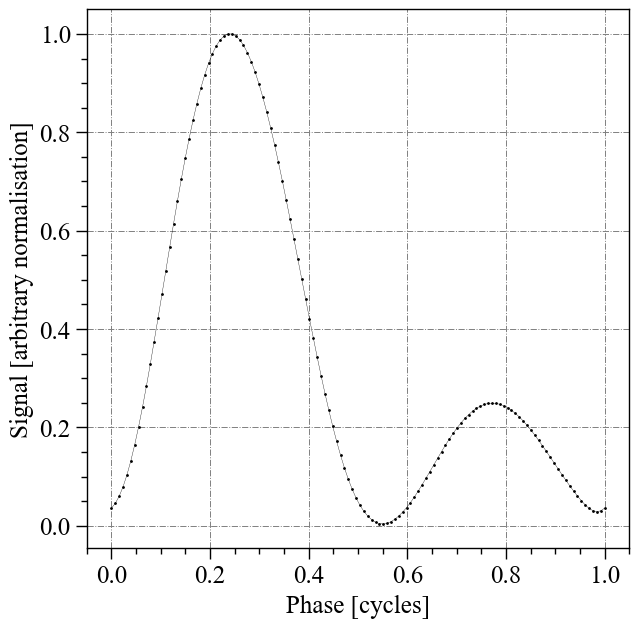

In [46]:
_ = plot_flux() #photosphere signal

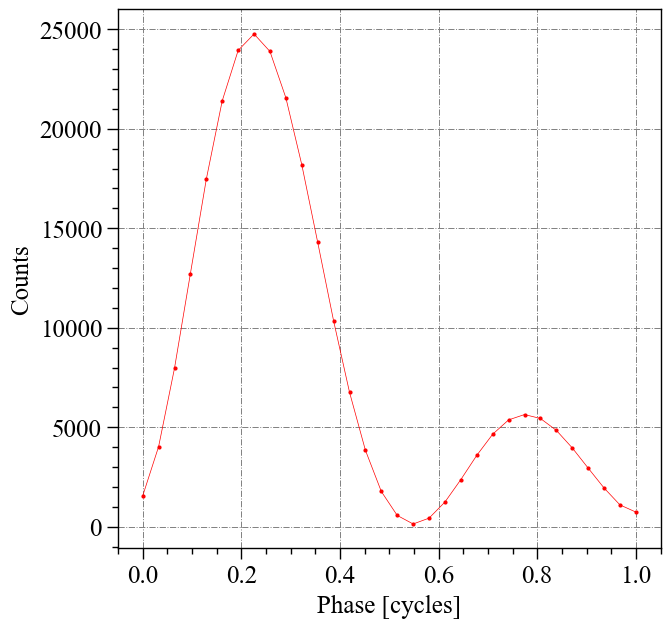

In [47]:
_ = plot_counts(HiXPSI_Crescent_Polar_plt) #registered counts

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

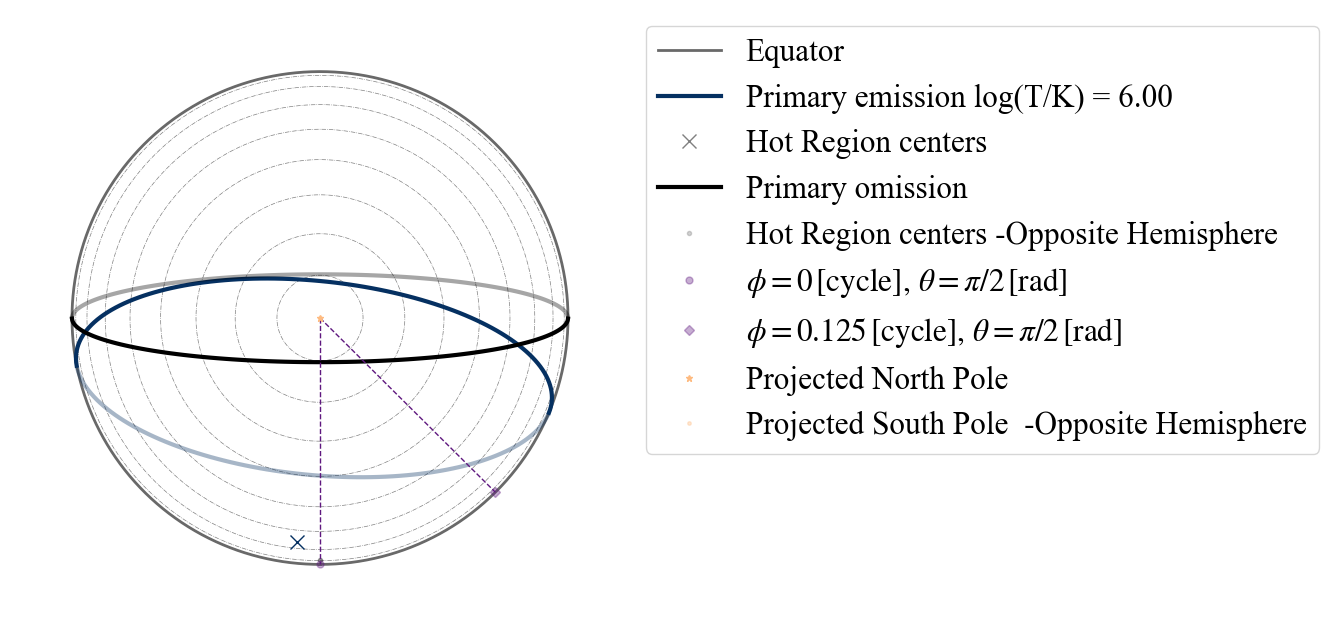

In [48]:
plot_projection_general(likelihood,"PST",[0,0,1],"NP",
                        SaveFlag = False)

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

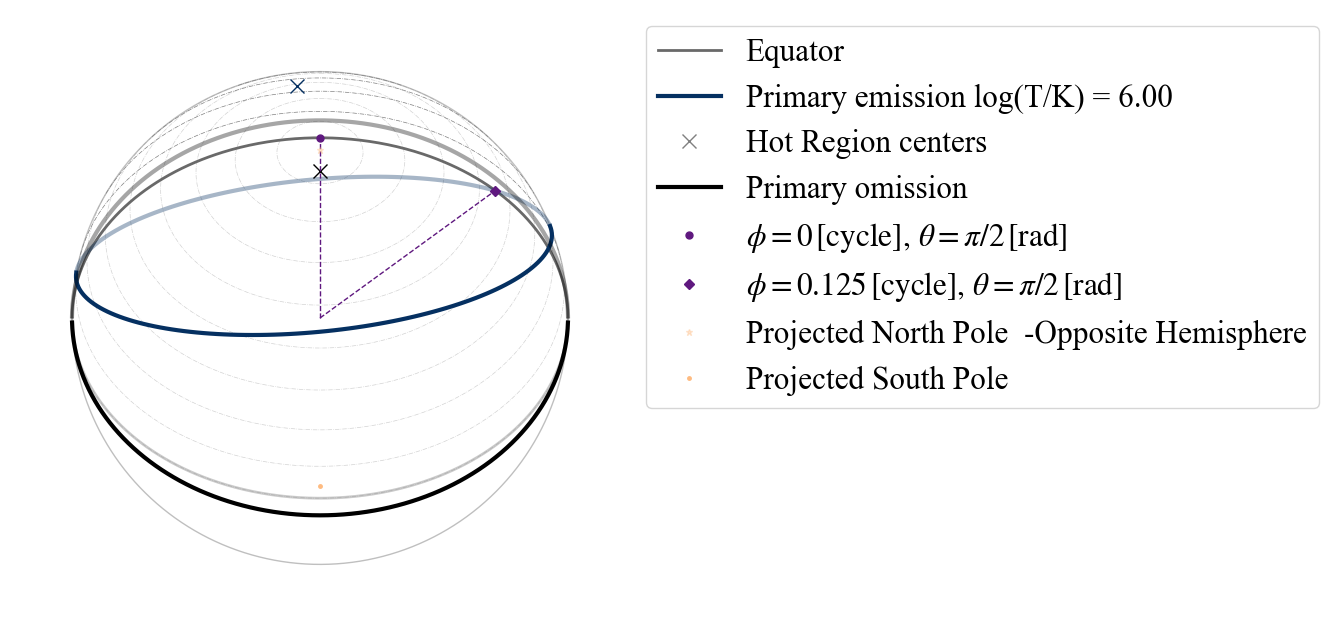

In [49]:
plot_projection_general(likelihood,"PST","I","NP",
                        SaveFlag = False)